In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import random as ra

from skimage.morphology import skeletonize
import networkx as nx
from scipy.ndimage import distance_transform_edt

import os
import re

In [3]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 10
        
epochs = 10            
batch_size = 1000 #just for loading more data easily
learning_rate = 0.001

In [4]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 32
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #32 - 16
        self.fc2 = nn.Linear(hidden_size1, out_size)       #16 - 10
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight) #only works with ReLU
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        x0 = self.relu(self.fc0(x))
        x1 = self.relu(self.fc1(x0))
        out = self.fc2(x1) #no ReLU because final decision would be altered, couldn't be "fixed" by other weights anymore, has to stay true!
        return out, [x0, x1, out]

In [6]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

file_pth = 'binary_ffn_all.pth'
net.load_state_dict(torch.load(file_pth)) #pre-trained

<All keys matched successfully>

In [7]:
with torch.no_grad():
    correct = 0
    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        outputs, _ = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 96.6 %


In [8]:
def extract_concepts(img):
    img_np = img.cpu().numpy()
    filtered = img_np > 0.5 #becuase skeleton works on binary 1, 0 data

    skeleton = skeletonize(filtered)
    skeleton_np = skeleton.astype(bool)

    size = 10
    maxoverlap = 7
    height, width = 28, 28

    neighbors_offsets = [(dy, dx) for dy in [-1,0,1] for dx in [-1,0,1] if not (dy == 0 and dx == 0)]

    def get_neighbors(p):
        y, x = p
        result = []
        for dy, dx in neighbors_offsets:
            ny, nx = y + dy, x + dx
            if 0 <= ny < height and 0 <= nx < width and skeleton_np[ny, nx]:
                result.append((ny, nx))
        return result

    groups = []
    groups_sets = []

    def dfs(path, visited):
        if len(path) == size:
            path_set = set(path)
            if not any(len(path_set & g) > maxoverlap for g in groups_sets):
                groups.append(np.array(path))
                groups_sets.append(path_set)
            return

        candidates = set()
        for p in path:
            for n in get_neighbors(p):
                if n not in visited:
                    candidates.add(n)

        for n in candidates:
            visited.add(n)
            dfs(path + [n], visited)
            visited.remove(n)

    all_pixels = list(zip(*np.nonzero(skeleton_np)))

    for start in all_pixels:
        dfs([start], set([start]))

    tensor_groups = torch.stack([
        torch.zeros((height, width), dtype=torch.uint8).index_put_(
            (torch.tensor(g[:, 0]), torch.tensor(g[:, 1])), 
            torch.ones(len(g), dtype=torch.uint8)
        ) for g in groups
    ])

    original_clusters = torch.zeros_like(tensor_groups)
    original_clusters = []

    for i in range(tensor_groups.shape[0]):
        mask = tensor_groups[i].numpy()
        inverted_mask = 1 - mask
        distance = distance_transform_edt(inverted_mask)
        within_range_mask = (distance <= 2).astype(np.float32)
        new_input = torch.from_numpy(img_np * within_range_mask).float()
        original_clusters.append(new_input)

    return tensor_groups, original_clusters

Text(0.5, 1.0, 'Label: 8')

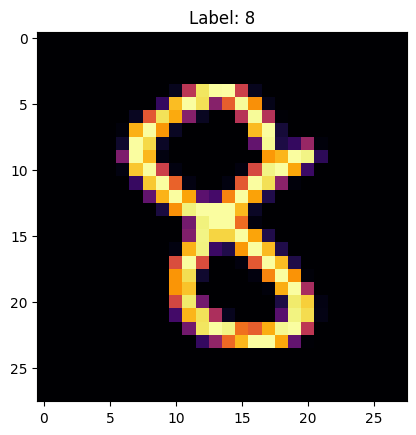

In [9]:
inputs, labels = next(iter(test_loader))

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == 8: #ra.randint(0, 9):
        img = inputs[ind].squeeze()
        break

plt.imshow(img, cmap="inferno")
plt.title(f"Label: {labels[ind].item()}")

In [10]:
digit_ints = [i for i in range(10)]
used_indices = []

In [11]:
for _ in range(0):
    for dig in digit_ints:
        while True:
            ind = ra.randrange(0, len(inputs))
            if labels[ind] == dig and ind not in used_indices:
                #used_indices.append(ind)
                img = inputs[ind].squeeze()
                break

        #tensor_groups, original_clusters = extract_concepts(img)
        #torch.save({'tensor_groups': tensor_groups,'original_clusters': original_clusters}, f"somefolder/concepts_dig_{dig}_ind{ind}.pt")


In [12]:
"""indn = 0"""

'indn = 0'

In [13]:
"""plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('extracted sub-concept')
plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')
plt.imshow(tensor_groups[indn].cpu().numpy(), cmap='inferno', alpha=0.6)

img2 = torch.where(
    img != 0,
    torch.tensor(img, device=img.device),
    0.0
)

plt.subplot(1, 2, 2)
plt.title('Concept Segment from Original')
plt.imshow(original_clusters[indn], cmap='gray')

plt.axis('off')
plt.show()

indn += 1"""

#################

pattern = re.compile(r'dig_(\d+)_ind(\d+)\.pt$')

files = []
for filename in os.listdir('stored_concepts'):
    match = pattern.search(filename)
    if match:
        dig = int(match.group(1))
        ind = int(match.group(2))
        files.append((dig, ind, filename))

files.sort()
used_indices = [ind for _, ind, _ in files]

In [14]:
#also possible: only find very small concepts (size = 3, maxoverlap = 0 or 1) 
# and then recombine those to larger ones, would be faster than dfs and work on gpu
#did it on cpu anyway, took 12mins

ind2 = 0

inputs, labels = next(iter(test_loader)) #in test_loader always same order if shuffle=False in batch
while True:
    rand_ind = ra.choice(used_indices)
    label, img = labels[rand_ind], inputs[rand_ind]
    if label == 2:
        break

label.item()

2

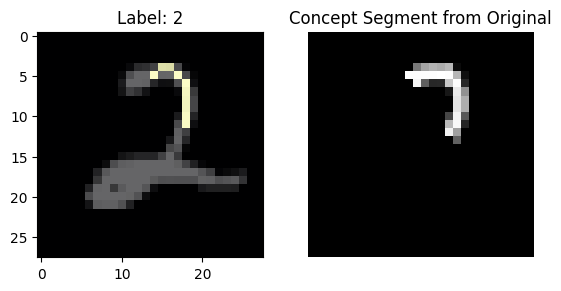

In [15]:
#creating lists of all tensors of all concepts stored:

pattern = re.compile(r'dig_(\d+)_ind(\d+)\.pt$')

files = []
for filename in os.listdir('stored_concepts'):
    match = pattern.search(filename)
    if match:
        dig = int(match.group(1))
        ind = int(match.group(2))
        files.append((dig, ind, filename))

files.sort()
used_indices = [ind for _, ind, _ in files]

tensor_groups_list = []
original_clusters_list = []

for idx in used_indices:
    data = torch.load(f"stored_concepts/concepts_dig_{labels[idx]}_ind{idx}.pt")
    tensor_groups = data['tensor_groups']
    original_clusters = data['original_clusters']

    tensor_groups_list.append(tensor_groups)
    original_clusters_list.append(original_clusters)
    
skeleton_tensors, original_clusters = tensor_groups_list[used_indices.index(rand_ind)], original_clusters_list[used_indices.index(rand_ind)]

plt.subplot(1, 2, 1)
plt.imshow(img.view(28, 28), cmap="gray") #or squeeze()
plt.imshow(skeleton_tensors[ind2].cpu().numpy(), cmap='inferno', alpha=0.6)
plt.title(f"Label: {label}")

plt.subplot(1, 2, 2)
plt.title('Concept Segment from Original')
plt.imshow(original_clusters[ind2], cmap='gray')

plt.axis('off')
plt.show()

ind2 = ind2 + 1 if ind2 < len(skeleton_tensors) - 1 else 0

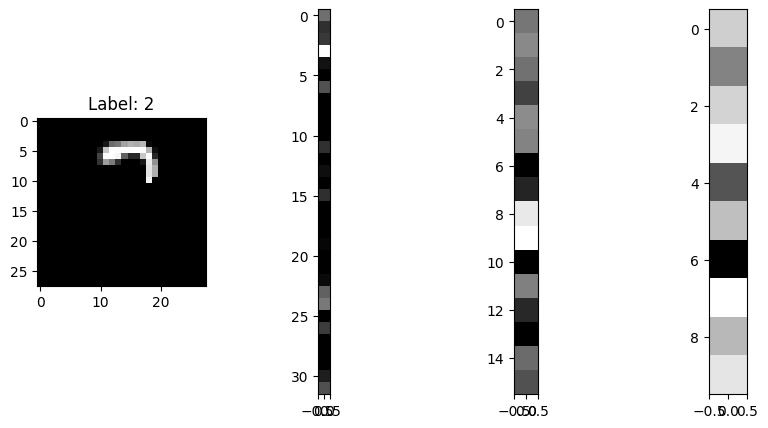

In [16]:
#this is forward pass: return out, [x0, x1, out]

def input_to_activation(inp):
    inp = inp.view(-1)
    net.eval()
    with torch.no_grad():
        _, activation_list = net(inp)

        return activation_list


#example to test:
act_list = input_to_activation(original_clusters_list[used_indices.index(rand_ind)][ind2].cuda())  #ra.randint(0, len(original_clusters_list)-1)][ra.randint(0, len(original_clusters)-1)])

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(original_clusters_list[used_indices.index(rand_ind)][ind2], cmap="gray")
plt.title(f"Label: {labels[rand_ind]}")

for i, vector in enumerate(act_list):
    s = vector.shape[0]
    plt.subplot(1, 4, i+2)
    plt.imshow(vector.view(s, 1).cpu().detach().numpy(), cmap="gray")

ind2 = ind2 + 1 if ind2 < len(skeleton_tensors) - 1 else 0

In [17]:
ind2 -= 2
#example: possible observation, only through clicking through it:
#n5 in second hidden layer may activate only on curves not open to the right or down, or lines, not that precisely though

In [18]:
#storing activations:

all_activations = []

for idx in used_indices:
    for idx2 in range(len(original_clusters_list[used_indices.index(idx)])):
        act_list = input_to_activation(original_clusters_list[used_indices.index(idx)][idx2].cuda())
        all_activations.append([act_list, (idx, idx2)])

In [19]:

def find_most_similar(all_activations, target, threshold):
    target_0, target_1, target_2 = target
    
    best_matches = []

    for i, triple in enumerate(all_activations):
        a0, a1, a2 = triple[0]

        d0 = torch.norm(a0 - target_0) #norm means euclidean dist
        d1 = torch.norm(a1 - target_1)
        d2 = torch.norm(a2 - target_2)
        total_distance = d0 + d1 + d2 #d0*0 + d1*0 + d2 is actually not too bad, has variation in hidden layer, but consistent in output, meaning different recombinations, same out

        if total_distance > threshold:
            continue
        else:
            best_matches.append([triple, total_distance, i])

    return best_matches


3

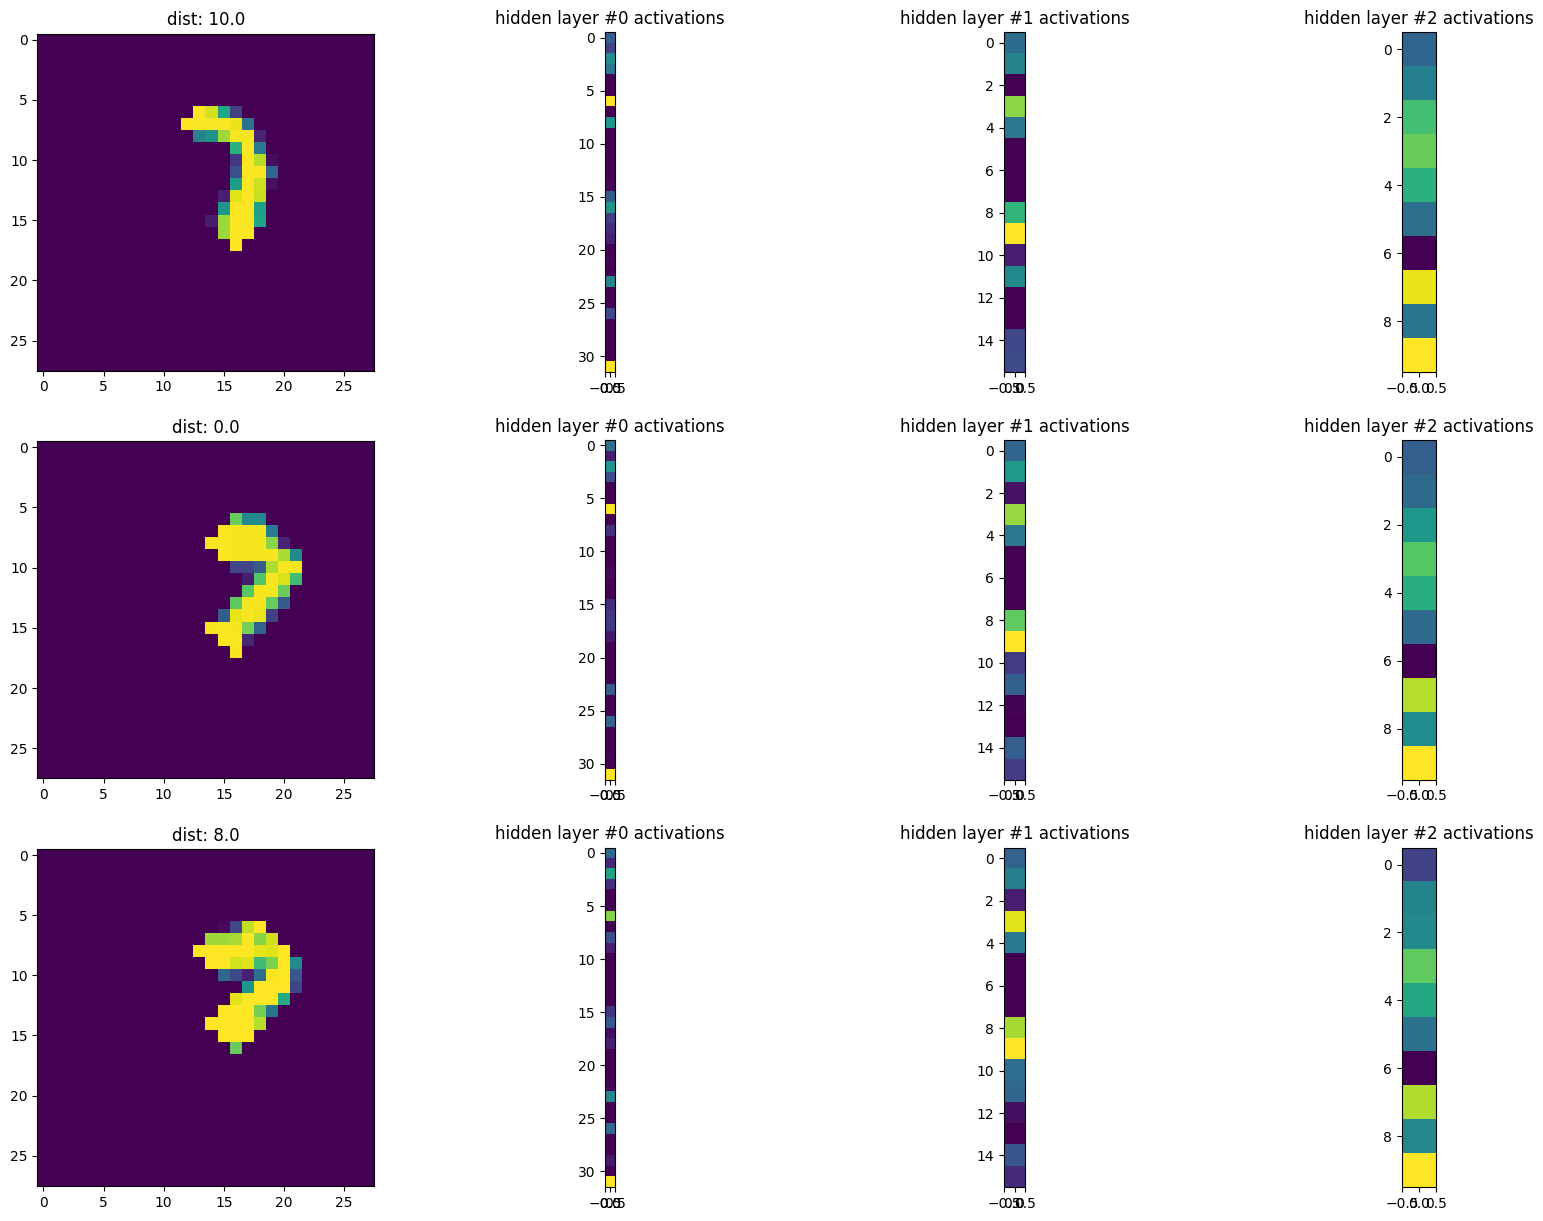

In [20]:

tar = all_activations[ra.randint(0, len(all_activations)-1)][0]
matches = find_most_similar(all_activations, tar, 10)
plt.figure(figsize=(20, len(matches)*5))

for i, match in enumerate(matches):
    triple = match[0]
    dist = match[1]
    ind = match[2]

    idx, idx2 = all_activations[ind][1]

    cluster = original_clusters_list[used_indices.index(idx)][idx2].cuda()

    plt.subplot(len(matches), 4, i*4+1)
    plt.imshow(cluster.cpu())
    plt.title(f"dist: {torch.round(dist)}")

    for j, vector in enumerate(triple[0]):
        s = vector.shape[0]
        plt.subplot(len(matches), 4, i*4+1+j+1)
        plt.imshow(vector.view(s, 1).cpu())
        plt.title(f"hidden layer #{j} activations")

len(matches)

#seems to be location boudn! perhaps the activations adhere to location because input neurons are based on location and only looking at similar activation means being dependant on that
#finding other relations where activations don't have to just be similar but have a specific new, learnt, relation could allow more precise recognition of low-level concepts, in any location
#angle is also a factor that is not currently generalised to, which is important as it would change the meaning of a feature (information it carries relevant to prediction)


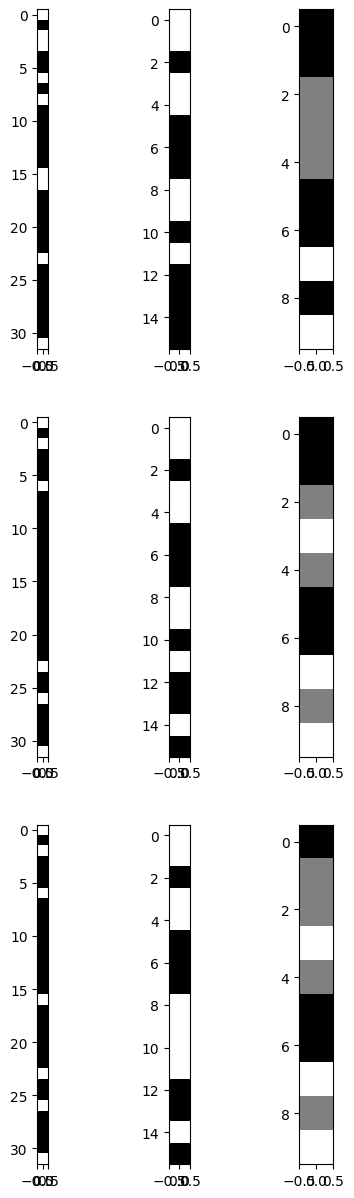

In [21]:
all_masks = []

for i, match in enumerate(matches):
    triple = match[0]
    masks = []

    for vector in triple[0]:
        limit = (torch.max(torch.abs(vector)) + torch.min(torch.abs(vector))) / 2
        masked_vec = torch.where(
            vector >=  limit / 2,
            torch.tensor(1.0, device=vector.device),
            torch.where(
                vector <= -limit / 2,
                torch.tensor(-1.0, device=vector.device),
                torch.tensor(0.0, device=vector.device) #just wrote this chained .where for nothing, I forgot I used ReLU -> no w<0 in hidden l
            )
        )

        masks.append(masked_vec)

    all_masks.append(masks)

plt.figure(figsize=(5, len(all_masks)*5))

for i, masks in enumerate(all_masks):
    for j, mask in enumerate(masks):
        plt.subplot(len(all_masks), 3, 3*i+j+1)
        s = mask.shape[0]
        plt.imshow(mask.view(s, 1).cpu(), cmap="gray")




[0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15]
[0, 1, 2, 4, 5, 6, 7, 8, 9]


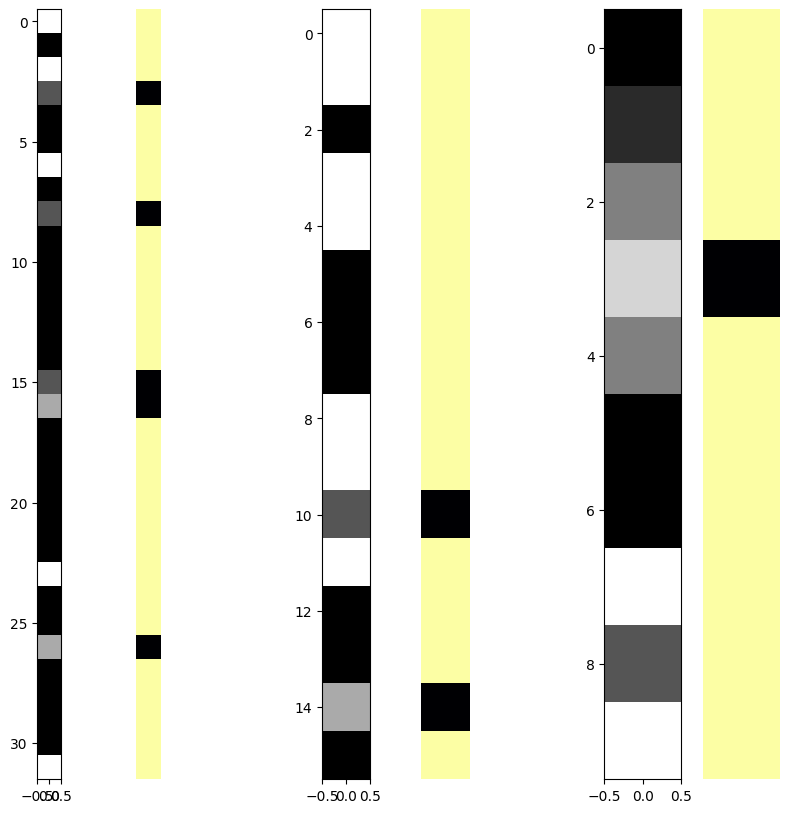

In [22]:

matching_mask_0 = torch.zeros((32))
matching_mask_1 = torch.zeros((16))
matching_mask_2 = torch.zeros((10))

matching_masks = [matching_mask_0, matching_mask_1, matching_mask_2]
out_negative_tensor = torch.zeros((10))

for masks in all_masks:
    for l, layer in enumerate(masks):
        for n in range(layer.shape[0]): #sorry about the ugly nesting...
            val = layer[n]
            matching_masks[l][n] = matching_masks[l][n] + val 
            
            if l == 2 and val < 0:
                out_negative_tensor[n] = out_negative_tensor[n] - 1

#normalising and adding indices part of relevant subnet:
act_l0 = torch.zeros((32))
act_l1 = torch.zeros((16))
act_l2 = torch.zeros((10))
act_list = [act_l0, act_l1, act_l2]

activation_indices = [[], [], []]

for l in range(3):
    for n, val in enumerate(matching_masks[l]):
        state = val / len(matches)
        matching_masks[l][n] = state

        binary = (state > 0.95 or state < 0.05)

        if binary:
            activation_indices[l].append(n)
        
        act_list[l][n] = binary


plt.figure(figsize=(10, 10))

plt.subplot(1, 8, 1)
plt.imshow(matching_mask_0.view(32, 1), cmap="gray")

plt.subplot(1, 8, 4)
plt.imshow(matching_mask_1.view(16, 1), cmap="gray")

plt.subplot(1, 8, 7)
plt.imshow(matching_mask_2.view(10, 1), cmap="gray")



plt.subplot(1, 8, 2)
plt.axis(False)
plt.imshow(act_l0.view(32, 1), cmap="inferno")

plt.subplot(1, 8, 5)
plt.axis(False)
plt.imshow(act_l1.view(16, 1), cmap="inferno")

plt.subplot(1, 8, 8)
plt.axis(False)
plt.imshow(act_l2.view(10, 1), cmap="inferno")

print(activation_indices[0])
print(activation_indices[1])
print(activation_indices[2])



In [68]:
import pygame

def draw_mnist_input(scale=20):
    pygame.init()
    size = 28
    window = pygame.display.set_mode((size*scale, size*scale))
    pygame.display.set_caption("Draw a digit (Press Enter to finish)")
    canvas = np.zeros((size, size), dtype=np.float32)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                break
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_RETURN:
                    running = False
                    break
            elif pygame.mouse.get_pressed()[0]:
                x, y = pygame.mouse.get_pos()
                grid_x, grid_y = x // scale, y // scale
                if 0 <= grid_x < size and 0 <= grid_y < size:
                    canvas[grid_y, grid_x] = 1.0  # Draw white
                    # Optional: draw nearby pixels for smoothing
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            nx, ny = grid_x + dx, grid_y + dy
                            if 0 <= nx < size and 0 <= ny < size:
                                canvas[ny, nx] = max(canvas[ny, nx], 0.5)

        # Draw scaled canvas
        for y in range(size):
            for x in range(size):
                val = int(canvas[y, x] * 255)
                pygame.draw.rect(window, (val, val, val), (x*scale, y*scale, scale, scale))

        pygame.display.flip()

    pygame.quit()
    return torch.tensor(canvas).unsqueeze(0)  # Shape: [1, 28, 28]


custom_tensor = draw_mnist_input()
custom_acivations = input_to_activation(custom_tensor.cuda())


19 31
Matching the few learnt concepts: 62.0%


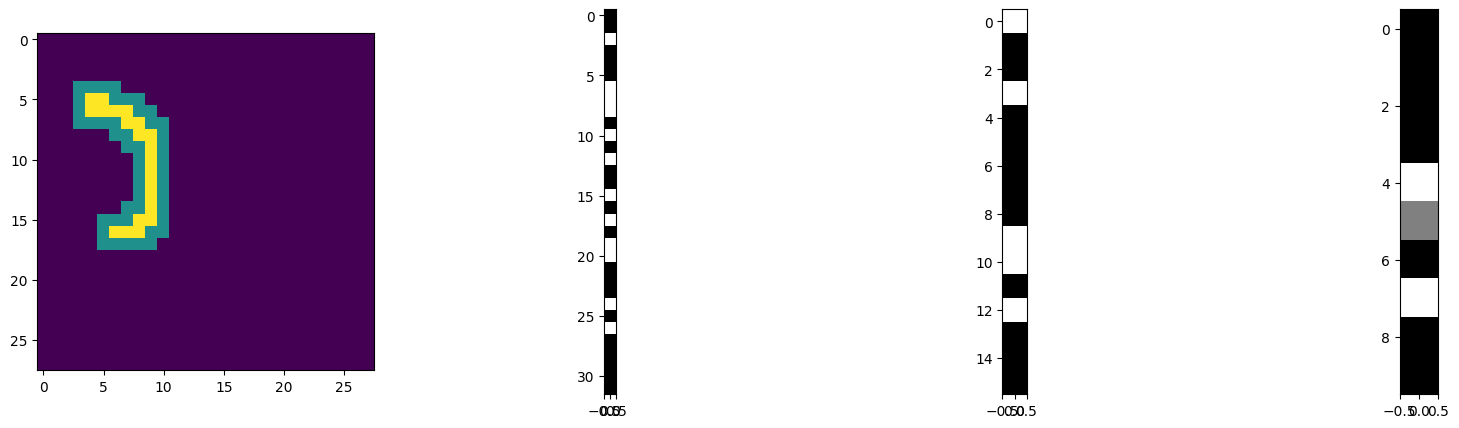

In [69]:
randin = ra.randint(0, len(all_activations)-1)
element = all_activations[randin]

acts = element[0]
idx, idx2 = element[1]

"""acts = matches[18][0][0]
ind = matches[18][2]

idx, idx2 = all_activations[ind][1]"""

cluster = original_clusters_list[used_indices.index(idx)][idx2].cuda()

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
#plt.imshow(original_clusters_list[used_indices.index(idx)][idx2])
plt.imshow(custom_tensor.squeeze())

masks = []

for vector in custom_acivations: #acts:
    limit = (torch.max(torch.abs(vector)) + torch.min(torch.abs(vector))) / 2
    masked_vec = torch.where(
        vector >=  limit / 2,
        torch.tensor(1.0, device=vector.device),
        torch.where(
            vector <= -limit / 2,
            torch.tensor(-1.0, device=vector.device),
            torch.tensor(0.0, device=vector.device)
        )
    )

    masks.append(masked_vec)

matching_binary_masks = []

for vector in matching_masks:
    limit = (torch.max(torch.abs(vector)) + torch.min(torch.abs(vector))) / 2
    masked_vec = torch.where(
        vector >=  limit / 2,
        torch.tensor(1.0, device=vector.device),
        torch.where(
            vector <= -limit / 2,
            torch.tensor(-1.0, device=vector.device),
            torch.tensor(0.0, device=vector.device) #just wrote this chained .where for nothing, I forgot I used ReLU -> no w<0 in hidden l
        )
    )

    matching_binary_masks.append(masked_vec)

mismatches = 0
notmismatches = 0

for i, indices in enumerate(activation_indices):
    layer = masks[i]

    plt.subplot(1, 4, i+2)
    plt.imshow(layer.view(layer.shape[0], 1).cpu(), cmap="gray")

    for idx in indices:
        if layer[idx] != matching_binary_masks[i][idx]:
            mismatches += 1
        else:
            notmismatches += 1


print(mismatches, notmismatches)
print(f"Matching the few learnt concepts: {round(notmismatches/(mismatches+notmismatches), 2) * 100}%")


#plt.imshow(cluster.cpu())

In [25]:
#next: get entire digit, the prediction, and the sub-nets influence on the decision, then reconstruct the decision making process with concepts only:
#segmentation + concept identification + comparison to learnt patterns for this class